# **POTATO_Skin_Diseases_Detection_Using_Deep_Learning**

In [1]:
%pip install --upgrade pip
%pip uninstall -y tensorflow
%pip install tensorflow matplotlib

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)
Note: you may need to restart the kernel to use updated packages.


Matplotlib is building the font cache; this may take a moment.


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",  #Directory containing the dataset
    shuffle=True,  #Shuffle the dataset
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  #Resize images to 256x256 pixels
    batch_size=BATCH_SIZE  #Batch size for training
    )




Found 2152 files belonging to 3 classes.


1000+152+1000=2152 total images
#  **Dataset Structure**
```
PlantVillage/
├── Potato___Early_blight
│   ├── 0a1b2c3d.jpg
│   ├── 0a1b2c3e.jpg
│   └── ...
├── Potato___Late_blight
│   ├── 0a1b2c4d.jpg
│   ├── 0a1b2c4e.jpg
│   └── ...
└── Potato___healthy
    ├── 0a1b2c5d.jpg
    ├── 0a1b2c5e.jpg
    └── ...
```
#  **Dataset Information**
- **Total Images**: 2152
- **Classes**: 3 (Potato___Early_blight, Potato___Late_blight, Potato___healthy)
- **Image Size**: 256x256 pixels

3 Classes are the folder name

In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
68*32  # 2176 images in total last batch was not proper 
# 32 was Batch size

2176

**Explore data**

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 2]


(32, 256, 256, 3)


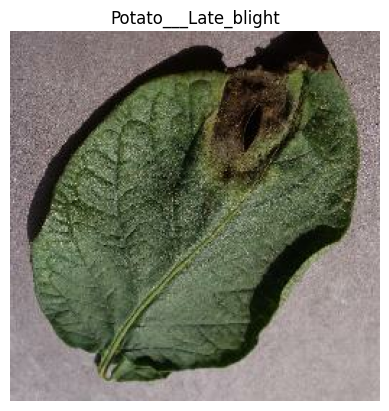

In [9]:
for image_batch, labels_batch in dataset.take(1):
    # print(image_batch[0]) # it will give image as a tensor
    # print(image_batch[0].numpy()) # it will give label as a numpy array
    print(image_batch.shape)  # (32, 256, 256, 3) 32 images of size 256x256 with 3 channels
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # Display the first image
    plt.axis("off")  # Hide the axis
    plt.title(class_names[labels_batch[0]])  # Display the label of the first


# Display a batch of images


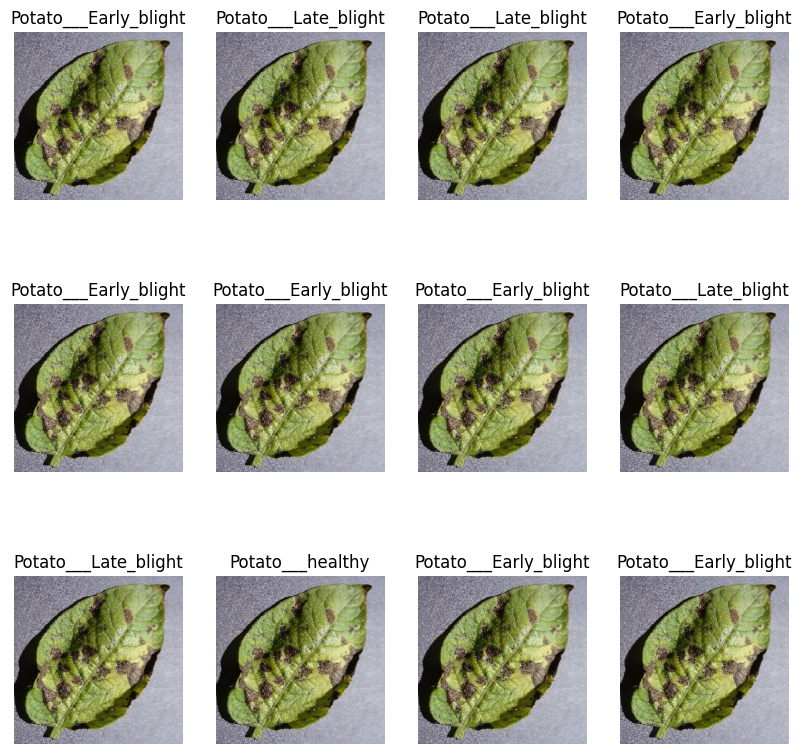

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))  
        plt.title(class_names[labels_batch[i]])  
        plt.axis("off")
        

# Split The dataset Into Test and Train

Validation and test datasets are 10% each, while the training dataset is 80%. With every epoch, the model will learn from the training dataset, validate its performance on the validation dataset, and finally test its accuracy on the test dataset.

After epoch we will use test dataset to check the accuracy of the model before the deploy.

**80% ==> training**

***20% ==> 10% ==> validation, 10% ==> test**

80% of 68

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds=dataset.take(54)  # 54 batches for training
len(train_ds)  # 54 batches for training

54

For test and validation we will use 10% each

In [13]:
test_ds=dataset.skip(54)  # Skip the first 54 batches for validtion and test
len(test_ds)  # 14 batches for validation and test

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds=test_ds.take(6)  # 6 batches for validation
len(val_ds)  # 6 batches for validation

6

In [16]:
test_ds=test_ds.skip(6)  # 6 batches for validation
len(test_ds)

8

# Function to Split Dataset into Train, Test and Validation

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=1000):

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

  
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

# Caching

for second iteration we will use the same dataset, so we will cache it to speed up the process. Data is in main memory.

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Pre-Processing

# 1. scaling

In [22]:
# resize_and_rescale = tf.keras.Sequential([
#     layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#     layers.experimental.preprocessing.Rescaling(1.0/255)
    
# ])

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])


# DataAugmention 

for making model Robust

with diffferent angles, brightness, contrast, etc.

In [24]:
# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.2)
# ])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])


# Build the model

We are using CNN for train the data

In [25]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=input_shape),
    tf.keras.layers.Rescaling(1.0/255),
    data_augmentation,   # Data augmentation

    # Apply 2D convolution (layers, kernel size, activation)
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)), # after CNN layer there is pooling layer max pooling or min #reduce size and preserve feature


    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes , activation='softmax')  # Output layer with softmax

])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [26]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# **layer-by-layer explanation**

---

### 🧱 Input Processing Layers

| Layer          | Type       | Output Shape        | Params | Explanation                                                                                |
| -------------- | ---------- | ------------------- | ------ | ------------------------------------------------------------------------------------------ |
| `resizing_1`   | Resizing   | (None, 256, 256, 3) | 0      | Resizes all input images to 256x256 with 3 channels (RGB). `None` is for batch size.       |
| `rescaling_1`  | Rescaling  | (None, 256, 256, 3) | 0      | Scales pixel values, usually dividing by 255 to normalize between 0 and 1.                 |
| `sequential_1` | Sequential | (None, 256, 256, 3) | 0      | This is likely your data augmentation block (e.g., flip, rotate). No trainable parameters. |

---

### 🧠 Convolutional Layers (Feature Extraction)

#### 🔄 Conv2D + Pooling Layers:

Each `Conv2D` layer learns features (edges, textures) using filters, and each `MaxPooling2D` reduces spatial size to control overfitting and improve efficiency.

| Layer              | Output Shape   | Params | Notes                                               |
| ------------------ | -------------- | ------ | --------------------------------------------------- |
| `conv2d_48`        | (254, 254, 32) | 896    | 32 filters, 3x3 kernel → **(3×3×3 + 1) × 32 = 896** |
| `max_pooling2d_48` | (127, 127, 32) | 0      | Downsamples by 2×                                   |
| `conv2d_49`        | (125, 125, 64) | 18,496 | **(3×3×32 + 1) × 64 = 18,496**                      |
| `max_pooling2d_49` | (62, 62, 64)   | 0      | Reduces spatial size                                |
| `conv2d_50`        | (60, 60, 64)   | 36,928 | Same formula, more input depth                      |
| `max_pooling2d_50` | (30, 30, 64)   | 0      | ↓                                                   |
| `conv2d_51`        | (28, 28, 64)   | 36,928 | ↓                                                   |
| `max_pooling2d_51` | (14, 14, 64)   | 0      | ↓                                                   |
| `conv2d_52`        | (12, 12, 64)   | 36,928 | ↓                                                   |
| `max_pooling2d_52` | (6, 6, 64)     | 0      | ↓                                                   |
| `conv2d_53`        | (4, 4, 64)     | 36,928 | ↓                                                   |
| `max_pooling2d_53` | (2, 2, 64)     | 0      | ↓                                                   |

---

### 🔢 Dense Layers (Classification)

| Layer       | Output Shape | Params | Explanation                                                               |
| ----------- | ------------ | ------ | ------------------------------------------------------------------------- |
| `flatten_7` | (256,)       | 0      | Flattens 2×2×64 into a 1D vector: 2×2×64 = 256                            |
| `dense_14`  | (64,)        | 16,448 | Fully connected layer: **(256×64) + 64 bias = 16,448**                    |
| `dense_15`  | (3,)         | 195    | Final output layer: **(64×3) + 3 bias = 195**, for 3-class classification |

---

### 📊 Summary

| Total Parameters | 183,747 |
| ---------------- | ------- |
| Trainable        | 183,747 |
| Non-trainable    | 0       |

---

### ✅ Final Output

* The final output is a **softmax vector of size 3**: each value represents the probability for each of the 3 classes.
* The shape `(None, 3)` means that for each input image, the model outputs 3 probabilities (summing to 1).

---


In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = model.fit(
    train_ds,
    epochs=EPOCHS ,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 784ms/step - accuracy: 0.4592 - loss: 0.9459 - val_accuracy: 0.4948 - val_loss: 0.8695
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 741ms/step - accuracy: 0.6153 - loss: 0.7798 - val_accuracy: 0.7604 - val_loss: 0.5995
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 743ms/step - accuracy: 0.7759 - loss: 0.5236 - val_accuracy: 0.8802 - val_loss: 0.3692
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 749ms/step - accuracy: 0.8578 - loss: 0.3457 - val_accuracy: 0.8542 - val_loss: 0.3813
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 760ms/step - accuracy: 0.8993 - loss: 0.2522 - val_accuracy: 0.8906 - val_loss: 0.2576
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 735ms/step - accuracy: 0.9053 - loss: 0.2112 - val_accuracy: 0.8542 - val_loss: 0.3301
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 758ms/step - accuracy: 0.9273 - loss: 0.1849 - val_accuracy: 0.9219 - val_loss: 0.2370
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 736ms/step - accuracy: 0.9285 - loss: 0.2038 - val_accu

In [31]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9556 - loss: 0.1179


In [32]:
scores

[0.07523994147777557, 0.9765625]

PLay With History

In [36]:
history

Parameters

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

it include with 4 parameters: loss, accuracy, val_loss, val_accuracy

In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [39]:
len(history.history['accuracy'])  # we can plot these history values in chart

50

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

we can plot these history values in chart   

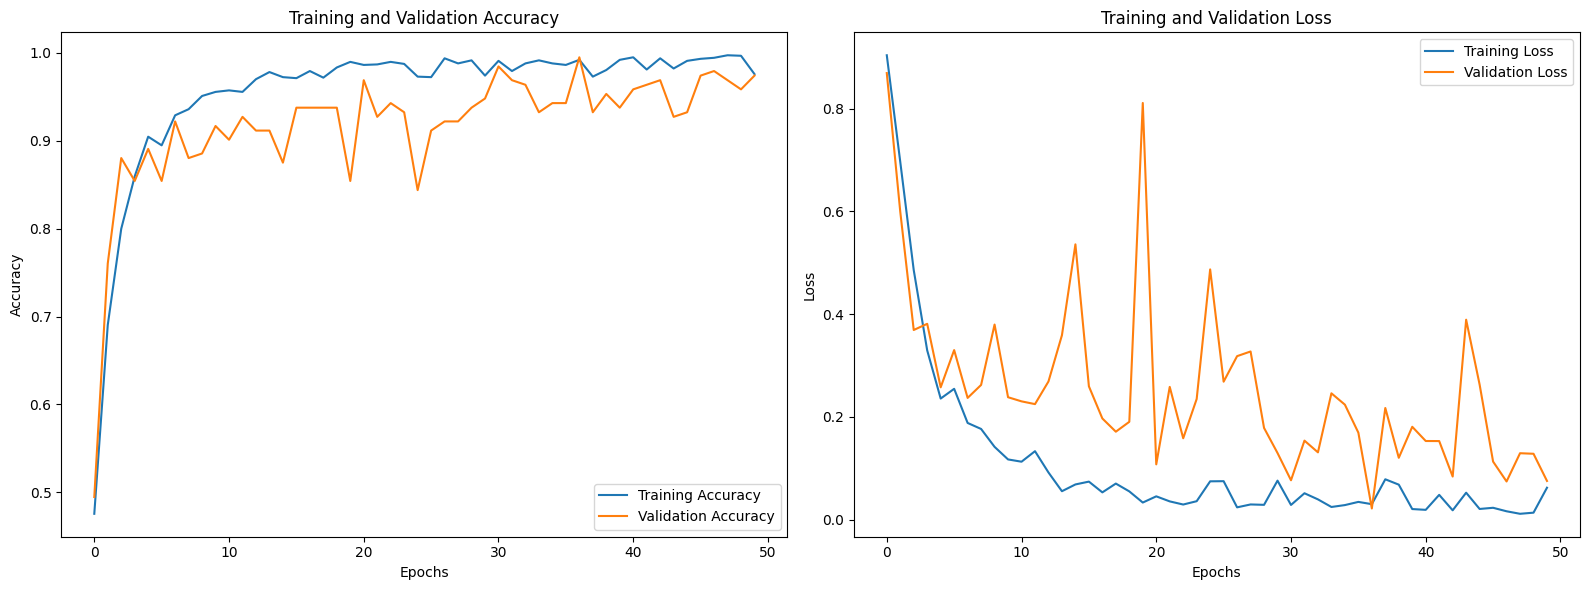

In [47]:


plt.figure(figsize=(16, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


# Make a Prediction

In [48]:
import numpy as np

In [53]:
np.argmax([2.189804e-04, 9.080725e-01, 9.170856e-02])  # output of the below prediction

np.int64(1)

First image to predict: 
First image's actual label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Batch prediction:  [3.8029847e-04 9.8462927e-01 1.4990475e-02]
Predicted label:  Potato___Late_blight


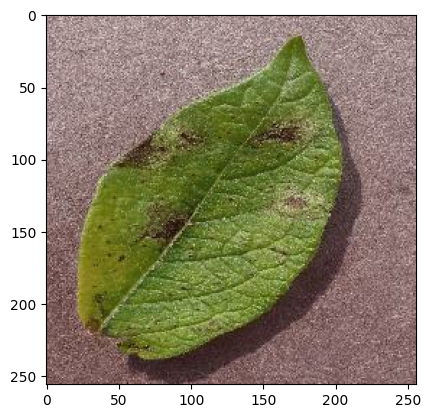

In [58]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')  # Display the first image in the batch
    first_label = labels_batch[0]  # Get the label of the first image

    print("First image to predict: ")
    plt.imshow(first_image)
    print("First image's actual label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Batch prediction: ", batch_prediction[0])
    # print(class_names[np.argmax(batch_prediction[0])])  # Display the predicted label for the first image
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

highest is actual class

In [81]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


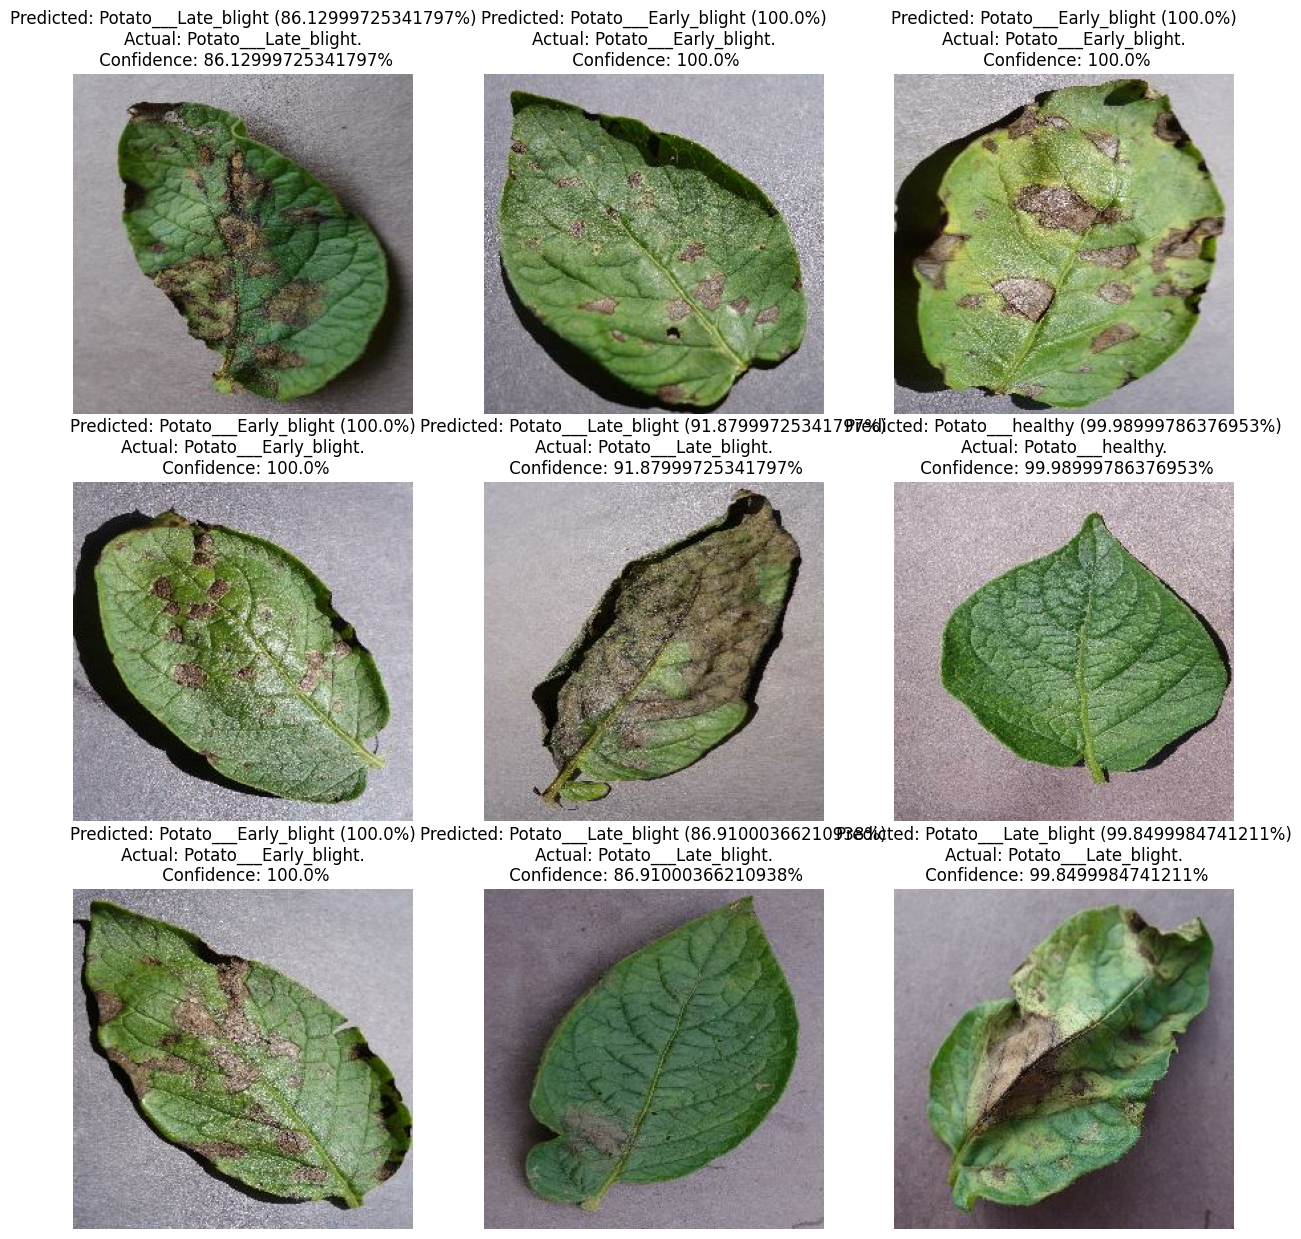

In [82]:
plt.figure (figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        # ax = plt.subplot(3, 4, i + 1)
        # plt.imshow(image_batch[i].numpy().astype("uint8"))
        # predicted_class, confidence = predict(model, image_batch)
        # plt.title(f"Predicted: {predicted_class} ({confidence}%)")
        # plt.axis("off")
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Predicted: {predicted_class} ({confidence}%)\nActual: {actual_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")




# Save The Models

# 1st version

In [96]:
import os

In [93]:
model_version=1
model.save(f"../saved_models/{model_version}.keras")

# 2nd version

In [ ]:
model_version=2
model.save(f"../saved_models/{model_version}")

Automate Version and save the model

# Auto increment version number and models saved

In [98]:
import os
# Get all folder/file names that are digits, convert to int, or use 0 if none
existing_versions = [int(i) for i in os.listdir("../saved_models/") if i.isdigit()]
model_version = max(existing_versions, default=0) + 1
model.save(f"../saved_models/{model_version}.keras")


In [102]:
import os
# Get all folder/file names that are digits, convert to int, or use 0 if none
existing_versions = [int(i) for i in os.listdir("../saved_models/") if i.isdigit()]
model_version = max(existing_versions, default=0) + 1
model.save(f"../saved_models/{model_version}.keras")  # Add .keras extension for Keras format

In [110]:
model_version = 2
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


Saved artifact at '../models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1916772498448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1916772486128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1916979932224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1916979928176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1916979934688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1916979932576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1916979934336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1916979936624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1916979936976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1916973203520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1916979936096: TensorSpec(shape=(), dty